In [24]:
%matplotlib inline

In [25]:
import numpy as np
from matplotlib import pyplot as plt

In [26]:
def spline_kernel(h, x):
    """Function that returns the kernel value according to cubic spline in 1D
    """
    q = abs(x)/h
    if(q <= 1.0):
        return (2.0/(3.0*h))*(1.0-(1.5*q*q*(1-(q/2.0))))
    elif(1.0 < q <= 2.0):
        return (2.0/(12.0*h))*(2.0 - q)*(2.0 - q)*(2.0 - q)
    else:
        return 0.0

In [27]:
def spline_diff(h, x):
    q = abs(x)/h
    if q == 0.0:
        return 0.0
    elif q <= 1.0:
        return (2.0/(3.0*h))*(-3.0*q + 9.0*q*q/4.0)*abs(x)/(h*x)
    elif 1 < q <= 2.0:
        return (-1.0/(2.0*h))*(2.0 - q)*(2.0 - q)*abs(x)/(h*x)
    else:
        return 0.0

In [28]:
def initialize():
    xl = np.linspace(-0.5, 0.0, 320, endpoint=False)
    xr = np.linspace(0.0125, 0.5, 40)
    x = np.concatenate([xl, xr])
    rhol = np.full(len(xl), 1.0)
    rhor = np.full(len(xr), 0.125)
    rho = np.concatenate([rhol, rhor])
    Pl = np.full(len(xl), 1.0)
    Pr = np.full(len(xr), 0.1)
    P = np.concatenate([Pl, Pr])
    v = np.full(len(x), 0.0)
    e = P/(0.4*rho)
    return x, rho, P, v, e

In [29]:
def derivatives(x, rho, P, v, e):
    m = 0.0015625
    alpha = beta = 1.0
    h = 0.025
    eta = 0.01*h*h
    x_der = np.zeros(len(x))
    rho_der = np.zeros(len(x))
    v_der = np.zeros(len(x))
    e_der = np.zeros(len(x))
    for i in range(len(x)):
        for j in range(len(x)):
            xij = x[i] - x[j]
            if (abs(xij) < (2*h)):
                vij = v[i] - v[j]
                cij = 0.5*(np.sqrt(1.4*P[i]/rho[i]) + np.sqrt(1.4*P[j]/rho[j]))
                rhoij = 0.5*(rho[i] + rho[j])
                if (vij*xij) < 0.0:
                    nuij = h*vij*xij/((xij*xij) + eta*eta)
                    piij = (-alpha*cij*nuij + beta*nuij*nuij)/rhoij
                else:
                    piij = 0.0
                k = (P[i]/(rho[i]*rho[i])+P[j]/(rho[j]*rho[j])+piij)
                v_der[i] += -m*k*spline_diff(h, x[i]-x[j])
                e_der[i] += 0.5*m*k*vij*spline_diff(h, x[i]-x[j])
                x_der[i] += 0.5*m*spline_kernel(h, x[i]-x[j])*(v[j]-v[i])/rhoij
    return v_der, e_der, x_der+v

In [30]:
def density(x, h):
    r = np.zeros(len(x))
    for i in range(len(x)):
        for j in range(len(x)):
            r[i] += 0.0015625*spline_kernel(h, x[i]-x[j])
    return r

In [31]:
def exact_solution(Pl, Pr, rhol, rhor):
    P5 = Pr
    P1 = Pl
    rho1 = rhol
    rho5 = rhor
    P3guess = np.linspace(Pl, Pr, 1000)
    u1 = u5 = 0.0
    gamma = 1.4
    sigma = (gamma-1.0)/(gamma+1.0)
    beta = 0.5*(gamma-1)/gamma
    error = np.zeros(len(P3guess))
    for i, p3 in enumerate(P3guess):
        temp1 = (p3 - P5)*np.sqrt((1.0-sigma)/(rho5*(p3+sigma*P5)))
        k3 = np.sqrt((1.0-sigma*sigma)*P1**(1.0/gamma)/rho1)
        temp2 = (P1**beta-p3**beta)*k3/sigma
        error[i] = abs(temp1 - temp2)
    P3 = P3guess[np.argmin(error)]
    P4 = P3
    rho3 = rho1*((P3/P1)**(1.0/gamma))
    k2 = np.sqrt(0.5*rho5*((gamma+1.0)*P3 + (gamma-1.0)*P5))
    u3 = u4 = u5 + (P3 - P5)/k2
    rho4 = rho5*(P4 + sigma*P5)/(P5 + sigma*P4)
    P = np.array([P1, P1, P3, P3, P4, P4, P5, P5])
    rho = np.array([rho1, rho1, rho3, rho3, rho4, rho4, rho5, rho5])
    U = np.array([u1, u1, u3, u3, u4, u4, u5, u5])
    e = P/((gamma-1.0)*rho)
    x = np.array([-0.5, -0.25, 0.0, 0.2, 0.2, 0.4, 0.4, 0.5])
    return P, rho, U, e, x

In [32]:
def sod(dt, tf):
    t = 0.0
    x, rho, P, v, e = initialize()
    P_exact, rho_exact, U_exact, e_exact, x_exact = exact_solution(1.0, 0.1, 1.0, 0.125)
    while t < tf:
        rho = density(x, 0.025)
        v_der, e_der, x_der = derivatives(x, rho, P, v, e)
        # rho += rho_der*dt
        v += v_der*dt
        e += e_der*dt
        x += x_der*dt
        P = 0.4*rho*e
        t = t + dt
    plt.figure(1)
    plt.plot(x, rho, label='SPH')
    plt.plot(x_exact, rho_exact, label='Exact')
    plt.xlim(-0.5, 0.5)
    plt.title('Plot of density vs x')
    plt.legend()
    plt.figure(2)
    plt.plot(x, v, label='SPH')
    plt.plot(x_exact, U_exact, label='Exact')
    plt.xlim(-0.5, 0.5)
    plt.title('Plot of velocity vs x')
    plt.legend()
    plt.figure(3)
    plt.plot(x, P, label='SPH')
    plt.plot(x_exact, P_exact, label='Exact')
    plt.title('Plot of pressure vs x')
    plt.xlim(-0.5, 0.5)
    plt.legend()
    plt.figure(4)
    plt.plot(x, e, label='SPH')
    plt.plot(x_exact, e_exact, label='Exact')
    plt.xlim(-0.5, 0.5)
    plt.title('Plot of energy vs x')
    plt.legend()


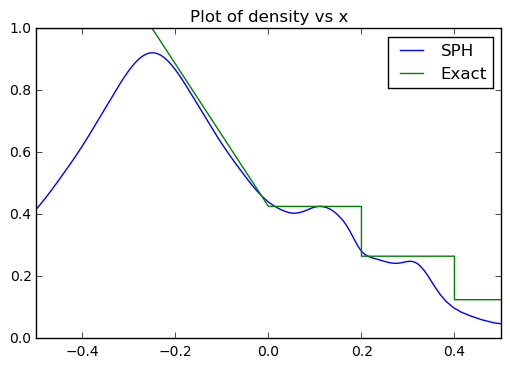

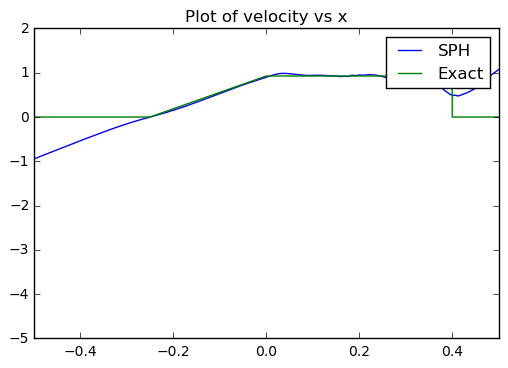

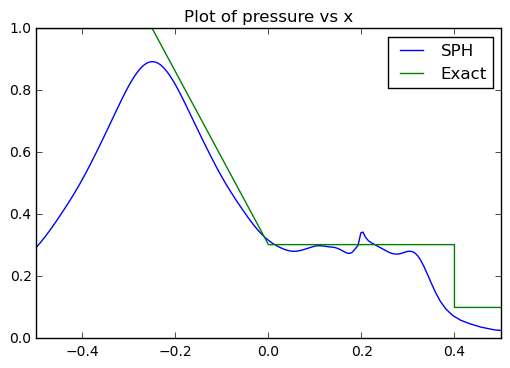

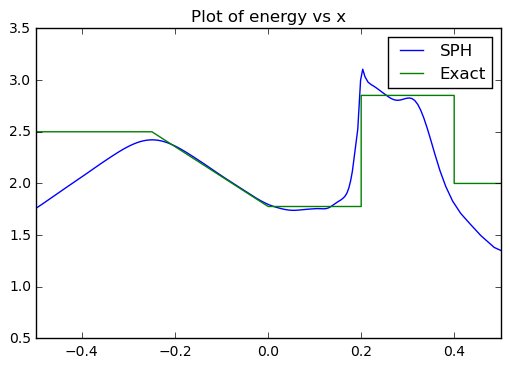

In [33]:
sod(0.0001,0.2)